In [1]:
import gpytorch

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced
from bo_functions import LHS_Design
from bo_functions import create_y_data
from bo_functions import test_train_split
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_y_expected
from bo_functions import improvement

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import ei_plotter_adv
from bo_plotters import improvement_plot

In [2]:
#Set noise parameters and load csv file to generate training data
noise_std = 0.1**2
all_p = LHS_Design("LHS_Toy_3_Input.csv")
all_y = create_y_data(all_p, noise_std)

#Separate training and testing data, uses default of an 80%/20% split
train_test_data = test_train_split(all_p,all_y)

train_p = train_test_data[0] #1x19
train_y = train_test_data[1] #1x19
test_p = train_test_data[2] #1x19
test_y = train_test_data[3] #1x19

In [3]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [4]:
#Set number of training iterations and train GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations)

In [5]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval();

In [6]:
#Calculates GP outputs for mean, variance, standard devaition, and y output
GP_Outputs = calc_GP_outputs(model,likelihood,test_p)

model_mean = GP_Outputs[0] #1x6
model_variance= GP_Outputs[1] #1x6
model_stdev = GP_Outputs[2] #1x6
model_y = GP_Outputs[3] #1x6

#Calculates expected y
y_exp = calc_y_expected(test_p, noise_std) #1x6

In [7]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(model_y, y_exp)[0] #Scaler
best_x = best_error_advanced(model_y, y_exp)[1] #1x3
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6
print(ei)

Upper bound is [ 2.61565578  0.          0.77041979 -1.44729042  0.8994551   0.7648626 ]
Lower bound is [ 2.4377567  -0.18289063  0.58683978 -1.61512961  0.7055947   0.5683192 ]
[-0.54203154  0.29875719 -0.4723358  -1.47706446 -0.65708823 -0.4201831 ]


In [8]:
#Test calc_ei_adv (to compare with hand calcs)
import numpy as np
import torch
f_best = 1.0
mu = torch.tensor([3])
y_exp = np.array([4])
pred_var = torch.tensor([1])
print(calc_ei_advanced(f_best,mu,pred_var,y_exp))

Upper bound is [2.]
Lower bound is [0.]
[-0.79259589]


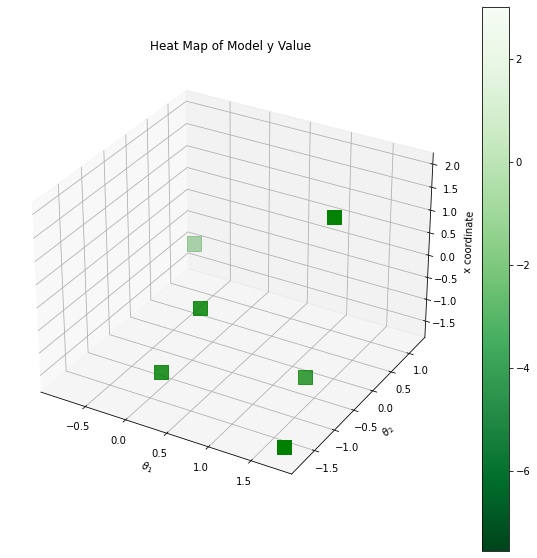

None


In [9]:
y_title = "Model y Value"
print(y_plotter_adv(test_p, model_y, y_title))

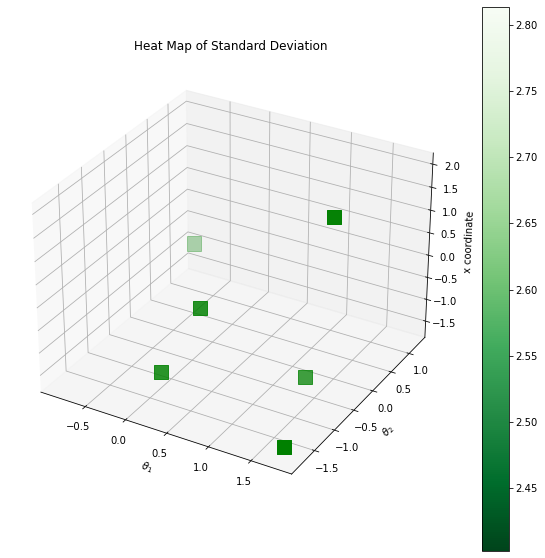

None


In [10]:
print(stdev_plotter_adv(test_p, model_stdev))

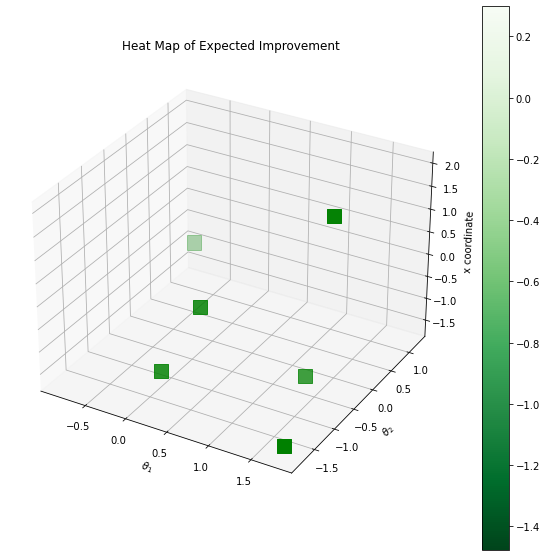

None


In [11]:
print(ei_plotter_adv(test_p, ei))

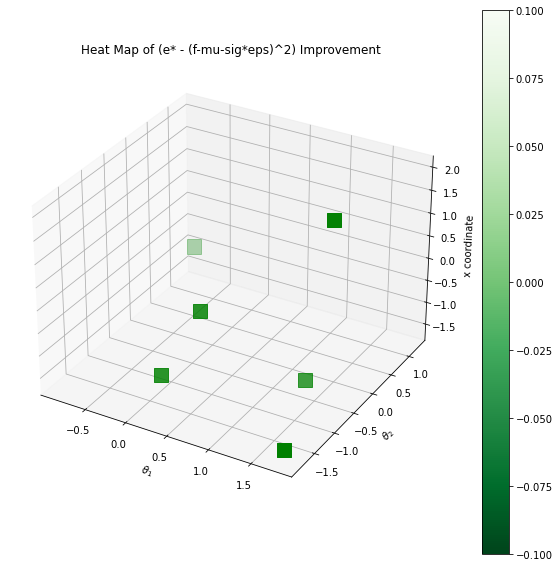

None


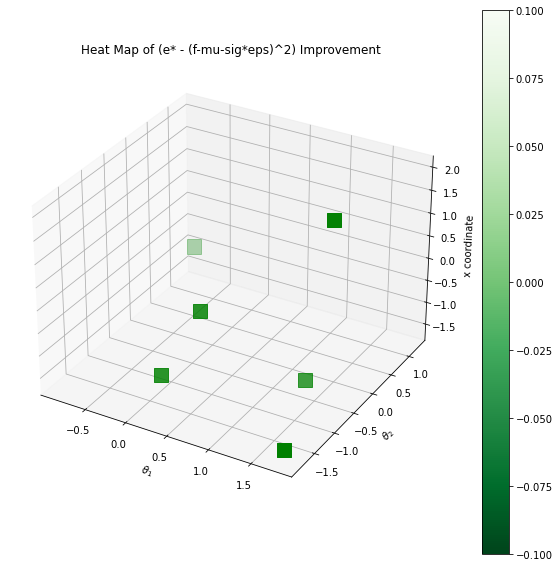

None


In [15]:
I_up = improvement(best_error,model_mean,model_variance, y_exp)[0]
I_low = improvement(best_error,model_mean,model_variance, y_exp)[1]
print(improvement_plot(test_p,I_up))
print(improvement_plot(test_p,I_low))